In [1]:
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Clean visual style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

# 📂 Load the dataset
df = pd.read_csv("../data/product_demand.csv")

# 👀 Quick preview
df.head()


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [2]:
# 🔎 Dataset shape and column names
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# 🔍 Check for nulls
print("\nMissing values:\n", df.isnull().sum())

# 🧠 Basic info
df.info()

# 📊 Basic stats
df.describe()


Shape: (1048575, 5)
Columns: ['Product_Code', 'Warehouse', 'Product_Category', 'Date', 'Order_Demand']

Missing values:
 Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Product_Code      1048575 non-null  object
 1   Warehouse         1048575 non-null  object
 2   Product_Category  1048575 non-null  object
 3   Date              1037336 non-null  object
 4   Order_Demand      1048575 non-null  object
dtypes: object(5)
memory usage: 40.0+ MB


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
count,1048575,1048575,1048575,1037336,1048575
unique,2160,4,33,1729,3828
top,Product_1359,Whse_J,Category_019,2013/9/27,1000
freq,16936,764447,481099,2075,112682


In [3]:
# Convert to datetime if needed
df["Date"] = pd.to_datetime(df["Date"])

# Unique product and warehouse counts
print("Unique Products:", df["Product_Code"].nunique())
print("Unique Warehouses:", df["Warehouse"].nunique())

# Check date range
print("Min Date:", df["Date"].min())
print("Max Date:", df["Date"].max())




Unique Products: 2160
Unique Warehouses: 4
Min Date: 2011-01-08 00:00:00
Max Date: 2017-01-09 00:00:00


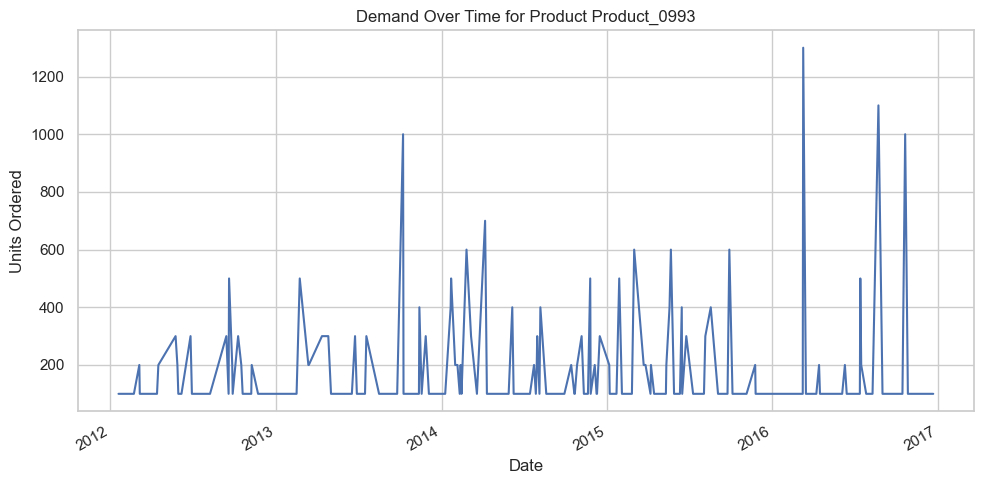

In [4]:
# 📈 Plot demand for a sample product
sample_product = df["Product_Code"].unique()[0]
product_df = df[df["Product_Code"] == sample_product]

product_df = product_df.groupby("Date")["Order_Demand"].sum().sort_index()

# Handle negative or string demand if needed
product_df = pd.to_numeric(product_df, errors='coerce')
product_df = product_df[product_df >= 0]  # Optional: remove negative demand

# Plot
product_df.plot(title=f"Demand Over Time for Product {sample_product}")
plt.ylabel("Units Ordered")
plt.xlabel("Date")
plt.tight_layout()
plt.show()


In [5]:
# 🧼 Clean Order_Demand column
df["Order_Demand"] = df["Order_Demand"].astype(str).str.replace("(", "-").str.replace(")", "")
df["Order_Demand"] = pd.to_numeric(df["Order_Demand"], errors="coerce")


In [6]:
from sklearn.preprocessing import LabelEncoder

# 🔠 Encode Product_Code and Warehouse
product_encoder = LabelEncoder()
warehouse_encoder = LabelEncoder()

df["Product_ID"] = product_encoder.fit_transform(df["Product_Code"])
df["Warehouse_ID"] = warehouse_encoder.fit_transform(df["Warehouse"])


In [7]:
# 🧮 Group and sum demand per day
df_agg = df.groupby(["Product_ID", "Warehouse_ID", "Date"]).agg({"Order_Demand": "sum"}).reset_index()

# 📅 Sort for time series
df_agg.sort_values(["Product_ID", "Warehouse_ID", "Date"], inplace=True)
df_agg.head()


,Product_ID,Warehouse_ID,Date,Order_Demand
0,0,0,2012-01-03,1000
1,0,0,2012-01-04,200
2,0,0,2012-01-09,2000
3,0,0,2012-01-10,3000
4,0,0,2012-01-30,200


In [8]:
# 🕒 Lag features
def create_lags(data, lags=[1, 7, 14]):
    for lag in lags:
        data[f"lag_{lag}"] = data.groupby(["Product_ID", "Warehouse_ID"])["Order_Demand"].shift(lag)
    return data

df_agg = create_lags(df_agg)


In [9]:
# 🔁 Rolling features
def create_rolling_stats(data, windows=[7, 14]):
    for window in windows:
        data[f"rolling_mean_{window}"] = data.groupby(["Product_ID", "Warehouse_ID"])["Order_Demand"].shift(1).rolling(window).mean()
        data[f"rolling_std_{window}"] = data.groupby(["Product_ID", "Warehouse_ID"])["Order_Demand"].shift(1).rolling(window).std()
    return data

df_agg = create_rolling_stats(df_agg)


In [10]:
# 🧹 Drop missing rows (from shifting/rolling)
df_agg.dropna(inplace=True)
df_agg.reset_index(drop=True, inplace=True)


In [11]:
# 🔍 Split date (e.g., last 30 days as test set)
cutoff_date = df_agg["Date"].max() - pd.Timedelta(days=30)

train = df_agg[df_agg["Date"] <= cutoff_date]
test = df_agg[df_agg["Date"] > cutoff_date]

print("Train size:", train.shape)
print("Test size:", test.shape)


Train size: (589372, 11)
Test size: (5714, 11)


In [12]:
# 🎯 Target
target = "Order_Demand"

# 🧠 Features
features = [col for col in df_agg.columns if col not in ["Order_Demand", "Date", "Product_Code", "Warehouse", "Product_ID", "Warehouse_ID"]]

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]


In [13]:
from xgboost import XGBRegressor

# ⚙️ Initialize and fit
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 🔮 Predict
y_pred = model.predict(X_test)

# 📊 Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 7047.75
RMSE: 30446.45


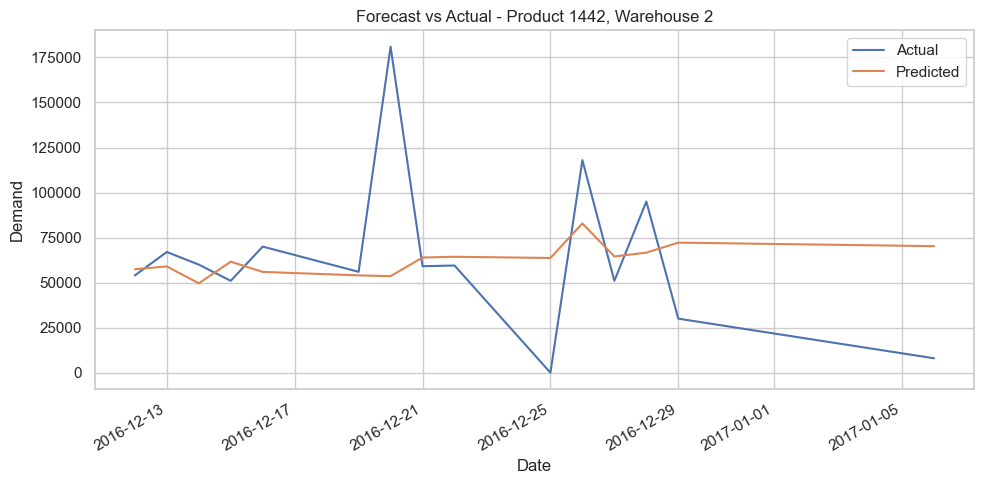

In [15]:
# Optional: pick 1 product-warehouse pair to visualize
sample_pair = test.groupby(["Product_ID", "Warehouse_ID"]).size().sort_values(ascending=False).index[0]
mask = (test["Product_ID"] == sample_pair[0]) & (test["Warehouse_ID"] == sample_pair[1])

# Create comparison DataFrame
comparison_df = test[mask][["Date"]].copy()
comparison_df["Actual"] = y_test[mask]
comparison_df["Predicted"] = y_pred[mask]

# 📈 Plot
comparison_df.set_index("Date")[["Actual", "Predicted"]].plot(title=f"Forecast vs Actual - Product {sample_pair[0]}, Warehouse {sample_pair[1]}")
plt.ylabel("Demand")
plt.tight_layout()
plt.savefig("../outputs/forecasts.png")
plt.show()


c:\Users\LexyC\OneDrive\Documents\Career-Portfolio-Projects\demand-forecasting\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


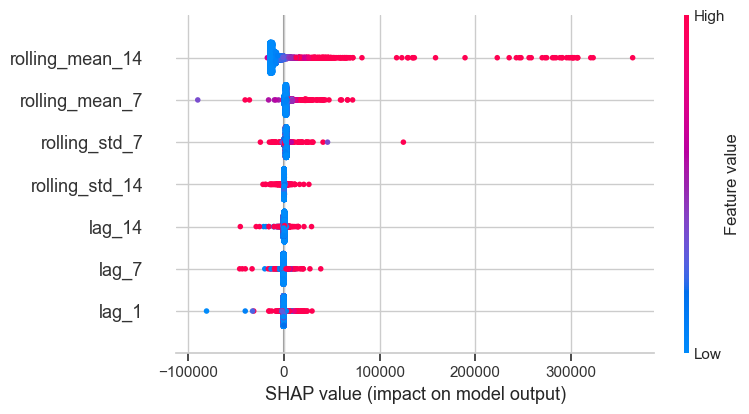

In [16]:
import shap

# 🧠 SHAP explainer for tree-based models
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# 🔍 Summary plot
shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()
plt.savefig("../outputs/shap_feature_importance.png")
plt.show()


C:\Users\LexyC\AppData\Local\Temp\ipykernel_17052\1279232134.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="RMSE", y="Model", palette="pink")


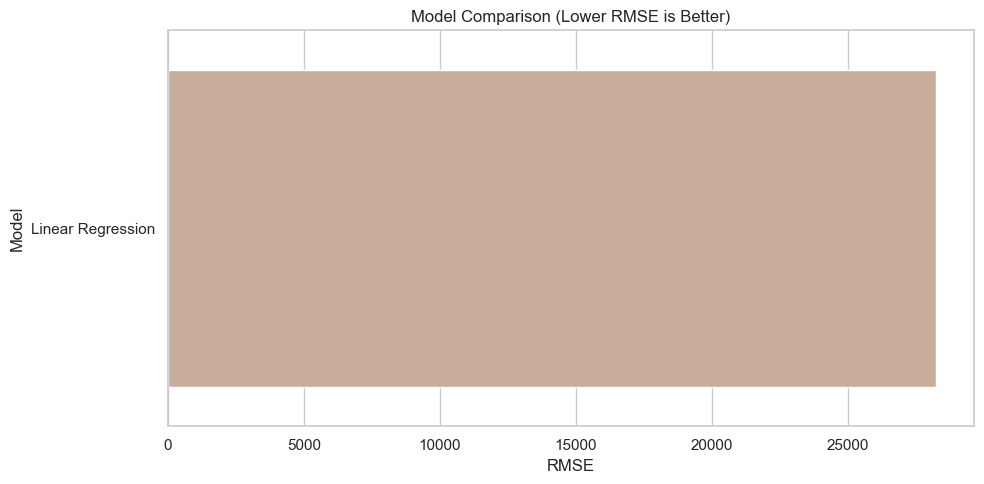

,Model,MAE,RMSE
0,Linear Regression,7066.467676,28226.529454


In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


# ⚙️ Train other models
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# 🧪 Evaluate all models
def evaluate_model(name, true, pred):
    return {
        "Model": name,
        "MAE": mean_absolute_error(true, pred),
        "RMSE": np.sqrt(mean_squared_error(true, pred))

    }

results = [
    evaluate_model("Linear Regression", y_test, lr_pred),
    evaluate_model("Random Forest", y_test, rf_pred),
    evaluate_model("XGBoost", y_test, y_pred)
]

# 📊 Turn into DataFrame
results_df = pd.DataFrame(results).sort_values("RMSE")

# 🧱 Bar Plot
sns.barplot(data=results_df, x="RMSE", y="Model", palette="pink")
plt.title("Model Comparison (Lower RMSE is Better)")
plt.tight_layout()
plt.savefig("../outputs/model_comparison.png")
plt.show()

results_df


In [19]:
%timeit evaluate_model("XGBoost", y_test, y_pred)

298 μs ± 18.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
